In [1]:
import numpy as np
import copy

from numpy.core.numeric import moveaxis

In [2]:
KEY_TIE = 'tie'
KEY_ONGOING = 'ongoing'
KEY_WON_P1 = 'won_p1'
KEY_WON_P2 = 'won_p2'
KEY_P1 = 1
KEY_P2 = 2

n_games = 50000#30000

alpha = 0.1
gamma = 1
init_epsilon = 0.8

win_reward = 1
lose_reward = -1
tie_reward = 5

In [3]:
def get_board_string(board):
    return str(copy.copy(board).reshape(9))

In [4]:
def update_state(state, _q_table, epsilon, player_id):

    next_board_string = get_board_string(state)
    q_values = np.zeros([3,3]) if _q_table.get(next_board_string) is None else _q_table.get(next_board_string)
    it = np.nditer(state, flags=['multi_index'])
    for x in it:
        if x != 0:
            q_values[it.multi_index] = np.nan

    if np.all(np.isnan(q_values)):
        return state
        
    r = np.random.rand()
    non_nan_idxs = np.argwhere(~np.isnan(q_values))

    if r < (1-epsilon):
        # find max of q table
        action_idx = np.where(q_values == np.nanmax(q_values))
        action_idx = (action_idx[0][0], action_idx[1][0])
    else:
        r_idx = np.random.randint(non_nan_idxs.shape[0])
        action_idx = non_nan_idxs[r_idx,:]

    new_state = copy.copy(state)
    new_state[action_idx[0], action_idx[1]] = player_id

    return new_state, action_idx

In [5]:
test_state_1 = np.array([[np.nan,2,0],[0,0,2],[0,0,1]])
test_state_2 = np.array([[1,2,2],[1,1,2],[0,1,1]])

test_q_table = {'states': [test_state_1],
            'q_values' :[np.array([[np.nan,np.nan,1],[1,1,2],[0,2,2]])]}
            
update_state(test_state_1, test_q_table, 1, 1)

(array([[nan,  2.,  0.],
        [ 1.,  0.,  2.],
        [ 0.,  0.,  1.]]),
 array([1, 0]))

In [6]:
def game_status(state):
    
    # check if someone has won
    possible_winning_comb = np.zeros((8, 3))
    possible_winning_comb[:3,:] = state
    possible_winning_comb[3:6,:] = state.T
    possible_winning_comb[6,:] = state.diagonal()
    possible_winning_comb[7,:] = np.fliplr(state).diagonal()
    
    for row in possible_winning_comb:
        if np.all(row == KEY_P1):
            return KEY_WON_P1
        elif np.all(row == KEY_P2):
            return KEY_WON_P2

    # check if tie
    if np.count_nonzero(state==0) == 0:
        return KEY_TIE

    return KEY_ONGOING

In [7]:
test_state_3 = np.array([[1,2,2],[1,2,2],[0,2,1]])
game_status(test_state_3)

'won_p2'

In [17]:
def feed_reward(q_table, board_history, reward, alpha, gamma):
    board_history.reverse()
    next_max = -1.0
    for hist in board_history:

        q_values = np.zeros([3,3]) if q_table.get(hist[0]) is None else q_table.get(hist[0])
        if next_max < 0: # first time
            q_values[hist[1]] = reward
        else:
            q_values[hist[1]] += alpha*(reward + gamma * next_max - q_values[hist[1]])


        next_max = np.nanmax(q_values)
        
        it = np.nditer(hist[2], flags=['multi_index'])
        for x in it:
            if x != 0:
                q_values[it.multi_index] = np.nan

        q_table[hist[0]] = q_values

    return q_table

In [18]:
q_table1 = {}     
q_table2 = {}

results = []

epsilon = init_epsilon
e_decay = epsilon/n_games

res_log_interval = 100
res_p1 = []
res_p2 = []
res_tie = []

rp1 = 0
rp2 = 0
rtie = 0

for i in range(n_games):

    if i % 100 == 0:
        res_p1.append(rp1)
        res_p2.append(rp2)
        res_tie.append(rtie)
        rp1 = 0
        rp2 = 0
        rtie = 0

    if i % 2000 == 0:
        print('game ', i)

    # init board
    board = np.zeros([3,3])
    q_val1 = np.zeros([3,3])
    q_val2 = np.zeros([3,3])
    result = None
    board_history1 = []
    board_history2 = []

    _status = KEY_ONGOING

    while _status == KEY_ONGOING:
        # player 1 move 
        board, action1 = update_state(board, q_table1, epsilon, KEY_P1)
        str_board = get_board_string(board)
        board_history1.append((str_board, action1, board))

        _status = game_status(board)
        if _status != KEY_ONGOING:
            result = _status
            break

        # player 2 move 
        board, action2 = update_state(board, q_table2, epsilon, KEY_P2)
        str_board = get_board_string(board)
        board_history2.append((str_board, action2, board))

        _status = game_status(board)
        if _status != KEY_ONGOING:
            result = _status
            break

    if _status == KEY_WON_P1:
        q_table1 = feed_reward(q_table1, board_history1, win_reward, alpha, gamma)
        q_table2 = feed_reward(q_table2, board_history2, lose_reward, alpha, gamma)
        rp1 += 1
    elif _status == KEY_WON_P2:
        q_table1 = feed_reward(q_table1, board_history1, lose_reward, alpha, gamma)
        q_table2 = feed_reward(q_table2, board_history2, win_reward, alpha, gamma) 
        rp2 += 1 
    elif _status == KEY_TIE:       
        q_table1 = feed_reward(q_table1, board_history1, tie_reward, alpha, gamma)
        q_table2 = feed_reward(q_table2, board_history2, tie_reward, alpha, gamma)  
        rtie += 1 
    else:
        print('ERROR: unexpected result')

    results.append(result)

    if epsilon > 0:
        epsilon -= e_decay
    else:
        epsilon = 0

print('done')

game  0
game  2000
game  4000
game  6000
game  8000
game  10000
game  12000
game  14000
game  16000
game  18000
game  20000
game  22000
game  24000
game  26000
game  28000
game  30000
game  32000
game  34000
game  36000
game  38000
game  40000
game  42000
game  44000
game  46000
game  48000
done


In [152]:
np.unique(results, return_counts=True)

array([ 5569, 33358, 11073])

Text(0.5, 1.0, 'Winning statistics of tictactoe')

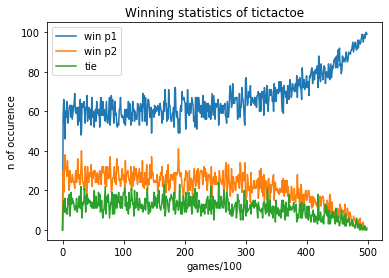

In [21]:
from matplotlib import pyplot as plt 

plt.plot(range(len(res_p1)), res_p1, label='win p1')
plt.plot(range(len(res_p2)), res_p2, label='win p2')
plt.plot(range(len(res_tie)), res_tie, label='tie')
plt.legend(loc="upper left")
plt.xlabel("games/100")
plt.ylabel("n of occurence")
plt.title("Winning statistics of tictactoe")


In [ ]:
__states1 = np.concatenate(q_table1['states'], axis=1)
__q_values1 = np.concatenate(q_table1['q_values'], axis=1)
__final1 = np.concatenate((__states1, __q_values1), axis=0)
np.savetxt("player1.csv", __final1, delimiter=",")

__states2 = np.concatenate(q_table2['states'], axis=1)
__q_values2 = np.concatenate(q_table2['q_values'], axis=1)
__final2 = np.concatenate((__states2, __q_values2), axis=0)
np.savetxt("player2.csv", __final2, delimiter=",")

In [ ]:
%store results_count
results_count

In [ ]:
%store results
results

Stored 'results' (dict)


{'won_p1': 2344, 'won_p2': 2324, 'tie': 300}